# Reinforcement Learning II - The Deep Version  

We looked at Reinforcement Learning (Q-Learning, actually) last time 22nd January 2018. We also had a brief tutorial-meetup 21st March 2018 for those who needed a quick intro to Python. In this follow-up, we are going to go deeper into Q-Learning by adding a Neural Network after we do a brief summary of Q-Learning from last time. For those who need a short and demonstrative introduction to Q-learning, try this page: http://mnemstudio.org/path-finding-q-learning-tutorial.htm

Or simply Google for Q-learning. There are many good tutorials, books and articles digitally available.

Note: We will show the Berkeley Grid World example from last time, but only briefly. To complete that would be a good exercise for you. 

We will be using another example in this session: A simple case of training a self-driving car.

The full presentation is a regular PowerPoint presentation. It is in the same directory as this Notebook. There are also notes (a README file) with info related to where to find what etc.

This Notebook contains only the Python AI module called ai.py (containing the machine learning code or the "intelligence" of the self-driving car) with explanations, simply because it is easier to explain Python code in a Jupyter notebook. There is also a ai_commented.py file that has a shorter version of the comments in the code itself, but we don´t really like so much comment in Python code. 

We will be using Python 2 (not 3).

## The libraries/modules to use 

As in many major programming language, learning the programming language alone is often not sufficient. One needs to learn the technology built around the language. It is the same for Python. One needs to understand what the very rich number of Python libraries/modules offer. 

Here is a list of "20 Python libraries you can’t live without":
https://pythontips.com/2013/07/30/20-python-libraries-you-cant-live-without/

In this module, which implements the "intelligence" of the self driving car that uses a neural network to extend Q-learning to Deep Q-Learning, we are going to be using a number of them. 

1 - numpy:
We will need numpy. We always need numpy. It is the most common numeric/scientific computing library used in Python.  

2 - os
We will need it for being able to store and restore (load) our model and the car in its current trained state in between trainings and experiments. 

3 - random:
We need randomness because we will be taking random samples/batches for implementing Experience Replay (explained in the presentation).  

4 - torch
This is our tensor-library for implementing the neural network. Life with a neural network (andconsequently deep learning) is difficult without tensors. I recommend that you Google what a tensor is, and then use some time to understand the PyTorch library that we are using in this case. You can find a good beginner tutorial here: http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html, but do take a look at the other (intermediate and advanced) tutorials that you can reach from here: http://pytorch.org/tutorials/. 

There are alternatives to PyTorch. The most obvious and the best known one is TensorFlow (originally by Google). PyTorch (developed originally by Nvidia and Facebook) is newer and more powerful - especially if you are going to do dynamic graphs and use CUDA. Founded by Nvidia, CUDA stands for "Compute Unified Device Architecture". According to Nvidia "CUDA is a parallel computing platform and programming model that makes using a GPU for general purpose computing simple and elegant" from practically any major programming language - like Python.

We will be using the "nn" module of the torch library for implementing our neural network. 

We will be using "functional" in nn, which gives us the various activation functions mentioned in the presentation (like the rectifier function).

We will be using the "optim" module for optimizing the Stochastic Gradient Descent (see the presentation).

We will be using one of the best known module, the "autograd" module and its "Variable" class, especially to handle tensor-variables (also with gradients) etc.

And we will be abbreviating the library/module names as usual.

Following is the import-section of the code:

In [ ]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

## Implementing the Neural Network - The Network Class

Next step is to create the neural network structur. For that, we will use a class (that we can instantiate various neural networks from) called "Network" with two member functions:

The mandatory "init" function to create an instance (an object) of the neural network class, and a "forward" function to activate the neurons 

### The "init" function

The first functions is the mandatory "init" function, which creates the neural network object and the input layer with a number of input neurons, with 1 hidden layer and an output layer with the possible actions.

Note that only 1 hidden layer is a "shallow" learning case. You can experiment with a neural network with more hidden layers to see how "deep" learning works out in this case.

__Implementation note:__ There will be 3 possible actions in our implemenattion later: left, right or straight. 

__Implementation note:__ When we create this neural network later, we will do so with 5 input neurons (i.e., 5 dimensions for the encoded vector of input states) - i.e., the three signals + orientation + negative orientation.

#### Why do we have 1 hidden layer in the code? Where is it specified in the code?

We have 1 hidden layer because we have two full connections in the init-function (fc1 and fc2) - first connection from input (input_size) to some 30 (hidden) neurons, and the second one from these 30 (hidden) neurons to the actions (nb_action). If we wanted another layer, we would have three full connections: Between input and 1st hidden layer, between 1st hidden layer and 2nd hidden layer, and finally from 2nd hidden layer to actions.

Here is a tutorial example with two hidden layers:
http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html


### The "forward" function

Our second function is the "forward" function, which will perform the forward flow and activate the neurons in the neural network.

Remember that we had several alternative activation functions? Check the presentation. 

In this case will use a __rectifier__ activation function. To help you remember: The diagram shows what the rectifier function looks like as comparet to a softplus function that we could also have picked.
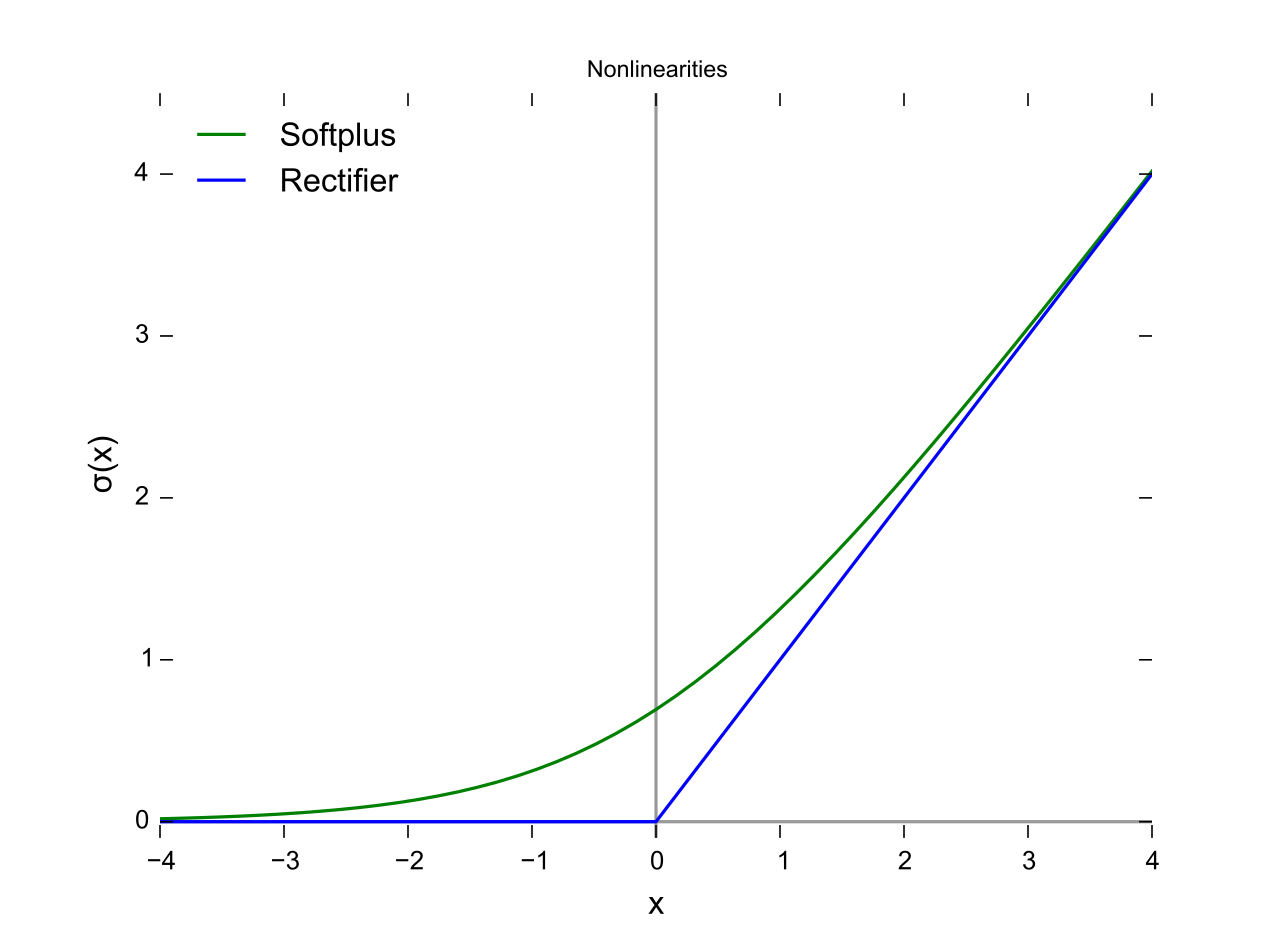

There are many reasons for choosing the rectifier function, but one important reason is that it is gradual and gives a result between a minimum and a maximum - not only a binary result like 0 or 1. Thus, using a rectifier function or its equivalent, we will be able to return one Q-value for each action with something akin to a probability (or level of certainty) of the action to take, if we take the resulting values and normalize them to a floating point value between 0 and 1. 

This way, it simply becomes easier to pick the correct (or the most certain) action - for example by picking the one equivalent to the maximum Q-value, or by using a softmax-style selection algorithm at the very end (which we will implement and discuss later).

__Note:__ As in the tutorial example referred to above, we inherit from nn.Module for creating the neural network because the mother module has most of what wee need of basic functionality for a neural network. A definite benefit of inheritance in the Object Oriented programming paradigm :-)

With these two functions, our Network class looks like this:

In [ ]:
class Network(nn.Module):
    
    # Initialize the object at creation
    def __init__(self, input_size, nb_action):
        super(Network, self).__init__()
        self.input_size = input_size
        self.nb_action = nb_action
        # First full connection btw input and hidden layers (30 neurons). PLAY WITH THIS!
        self.fc1 = nn.Linear(input_size, 30)
        # Second full connection between hidden layer and output layer
        self.fc2 = nn.Linear(30, nb_action)
        
    # ACTIVATE THE NEURONS: Forward propagation
    def forward(self, state):
        # Hidden layer with rectifier function
        x = F.relu(self.fc1(state))
        # Return the output neurons (Q-values)
        q_values = self.fc2(x)
        return q_values

## Implementing Experience Replay - The ReplayMemory class

We will want to put more than only the last state (only the previous transaction) into memory. We may want to have 100 states, 1000 states or maybe 100 000 states in memory. 

So we want a "long term memory" as our replay memory. 

And then we want a function that can append a new event or transaction to the memory, but in such a way that the memory size newer exceeds its maximum. Note that we want an append, which means that the newest is the last one and the oldest is the first one. We need to be clear about this because we will want to delete the oldest (the first) when adding one more event to the memory will imply exceeding the maximum size. Think of this long term memory. as a Python list (which starts from index 0). When we are to delete the oldest, we will always be deleting the element at index 0.

We alse want a function for getting random batches (samples) from our long term replay memory. But there is a technical trick there... Since we want to use the memory sample in PyTorch, we will first need to re-stack the structure of the replay memory batch (gathering states with states, events with events and rewards with rewards) and then map it into a PyTorch variable. The code is blow, but an example is necessary.

Assume that we have a list of triples (state, action, reward). Something like this:

    batch_list = ((s1, a1, r1), (s2, a2, r2))

What we want is to create a new PyTorch-friendly list, like this:

    recollected_list = ((s1, s2), (a1, a2), (r1, r2)). 

As I mentioned before, we collect the states all grouped together in the first element, and the events in the next etc. That is what the "zip" function in the "sample" member function below will do. 

This gets a bit tricky (and will be worse in th next class), so ... I strongly recommend you Google PytOrch tutorials and examples or use the ones I mentioned before.

Note that our event is not 3 but 4 elements (Last state, next state, last action and last reward) and can be modified to fit our need.

To summarize: Our ReplayMemory class has three member functions:

1. We start with the mandatory "init" function as usual, which initiates a long term replay memory structure with a "capacity" (max number of transactions) and a memory as an empty list initially. 

2. We will append to this list with the "push" function as we go along, and then push out the oldest to add a new one when it gets to "capacity" size. 

3. We get our random samples using the "sample" function zipped into the right structure as explained above.


In [ ]:
class ReplayMemory(object):
    
    # Initialize memory with a certain capacity
    def __init__(self, capacity):
        self.capacity = capacity 
        self.memory = []
    
    # Append to memory
    def push(self, event):
        self.memory.append(event)
        # Make sure the memory contains exactly "capacity" nr of transactions
        if len(self.memory) > self.capacity:
            # Delete the oldest element if at max capacity
            del self.memory[0]
        
    # Get random samples from memory - see explanation of the use of *zip above
    def sample(self,batch_size):
        samples = zip(*random.sample(self.memory, batch_size))
        # Create PyTorch variables concatanating with respect to first agrument (which is state)
        return map(lambda x: Variable(torch.cat(x, 0)), samples)

## Implementing Deep Q-Learning - The Dqn (Deep Q-Network) class

The Dqn class is where we implement our deep Q-learning model using neural networks. 

The class has 6 member functions, where the first 4 relate to the initiation and  implementation of neural network and the dep Q-learning model:

1. The usual "init" function creating and initiating the neural network based model.
2. The "select_action" function to select the correct action in a given state.
3. The "learn" function for training the deep learning network.
4. The "update" function for updating all elements (state, action, reward etc.) for each step.

The 5th one is the "score" function for computing the mean of all the rewards in a sliding window of events. 

The last two functions are "store" and "load", for storing and loading the experience (the trained network). 

### The "learn" function

A few words about **the "learn" function** first, since that really is the core to the machine learning part of the implementation.

Learn function trains the deep learning network. This means that it does forward and then backwards propagation. The aim is to get an output, compare it to the target (calculate "cost"), and then correct the weights to minimize cost. The weights are adjusted according to the earlier weights, i.e., according to how much they contributed to the error.

Remember that we use Gradient Descent for finding minima. 

Note that calculations are being done on the batches, not a single "state, next state, reward". Though looking at one state and immediate next states is a good way of explaining and formulating the mechanism of reinforcement learning, the data will be too little to learn anything from. So we take larger batches for training.  

The three signals (left, right, forward) reflect the density of the sand around. 

### Commented Dqn class

We explained the role of the learn function, but the its implementation together with the implementation of the rest of the Dqn class is a bit tricky to explain in a preamble like this. So I am simply including the code with line-by-line comments that I did for myself in my struggle to understand what should be and where and how. 

This commented version will most likely run if you remove the formatting and text in between, but we don´t like so richly commented Python code. The code itself is in the next cell

Here is the line-by-line commented Dqn class:

**class Dqn():**
     
    # Create the NN model. Same structure as the NN network. Don´t forget the gamma-parameter (ref. the presentation)
    
    def __init__(self, input_size, nb_action, gamma):
        
        # The gamma parameter
        self.gamma = gamma
        
        # Mean of the last so many rewards (100, sliding window)
        self.reward_window = []
        
        # Create the network (the NN model)
        self.model = Network(input_size, nb_action)
        
        # Create the memory for 100 000 transitions/events
        self.memory = ReplayMemory(100000)
        
        # lr is Learning Rate. Give the AI some time to learn. Try different.
        self.ptimizer = optim.Adam(self.model.parameters(), lr = 0.001)
        
        # State is 5-dim: 3 signals of the 3 sensors, orientation and minus-orientation
        # A vector that needs to be a Torch tensor
        # The network needs a batch of observations in the right formnat
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        
        # Check action2rotation which is 0, 20 or -20 degrees. Intialize to 0.
        self.last_action = 0
        
        # Reward is a float btw -1 and +1
        self.last_reward = 0

    # Selecting the right action (i.e., right, left, forward) from the Q-values of actions (output of the NN)
    # We need to pass the state to it. State = The three signals + orientation + negative orientation
    # We will be getting three Q values: Q values for left, right or straight actions.
    # We then have to select the most likely one... And maybe not, depending upon the randomness we introduce.
    
    def select_action(self, state):        
        
        # Softmax is the best action selection mechanism when we want to go on exploring other actions
        # It gives us the probabilities for each Q-value (OBS! Do not take the max directly with argmax)
        
        # Note that state is a PyTorch tensor, containing a gradient as well
        # Volatile drops the gradient (this is input, we don´t need the gradient)
        
        # Note that T is temperature to increase the probability of choosing the better Q-value.
        # Increasing the temperature parameter will make the intelligence more "certain".
        # softmax([1,2,3]) = [0.04, 0.11, 0.85] => softmax([1,2,3]*3) = [0, 0.2, 0.98]
        # We will play a bit with T in the demo.
        
        probs = F.softmax(self.model(Variable(state, Volatile = True))*7) # Temp = 7 
        
        # Now pick the action with highest probability - but... 
        # we do a random draw using multinomial! Remember: Never stop exploring!
        action = probs.multinomial()
        
        # Remember that we´ve packed the information as in the PyTorch variable with the state batch.
        # Now that is where the chosen action is. At 0,0.
        return action.data[0,0] 

    # The training/learning function
    
    def learn(self, batch_state, batch_next_state, batch_reward, batch_action):
        
        # Outputs from the batch states will give us all three actions. We want the chosen action only.
        
        # OBS! Remember that index 0 was state. Index 1 is action.
        
        # Unsqueezing and squeezing gives us a regular vector.
        # We needed the batch info as a tensor only for the NN. Not any longer.   
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
        
        # We need the next output for calculating the target = (gamma x next output) + reward
        # Next output is the next input to the NN (i.e., the model) 
        # Next stat (ind. 0) of the max of actions (ind. 1)
        next_outputs = self.model(batch_next_state).detach().max(1)[0]
        
        # As above = (gamma x next output) + reward. OBS! All in batches.
        target = self.gamma*next_outputs + batch_reward
        
        # Temporal difference based loss with smooth_l1_loss function on predictions (outputs) and targets 
        td_loss = F.smooth_l1_loss(outputs, target)
        
        # Backwards propagation: Use optimizer. Initialized at "init". Must be re-initialized.
        self.optimizer.zero_grad()
        
        # Now that the optimizer is re-initialized, backward propagate. 
        # This frees memory since we´re going to do this many times, and increase performance.
        # retain_variables = True does that, and increases learning performance considerably.
        td_loss.backward(retain_variables = True)
        
        # With the loss propagated back to the network, the optimizer.step function updates the weights!
        self.optimizer.step()
    
    # Update all element:
    # last action becomes new action, last state becomes new state, last reward becomes new reward
    # Note that the connection back to the "map" (the application) is here. Check the update function used there.
    
    def update(self, reward, new_signal):
        # Upodate when reaching the new state wrt to the new_signal detected.
        # Concvert the 5-element signal to a Torch tensor. Unsqueeze to add batch state (ind 0).
        # Take a look at this to understand unsqueeze: http://pytorch.org/docs/master/torch.html#torch.unsqueeze
        new_state = torch.Tensor(new_signal).float().unsqueeze(0)
        
        # Use the push-function we made. 
        # Convert the last_action (just a number) to a tensor of 1 element in [] beacuse all others are tensors.
        self.memory.push((self.last_state, new_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward])))
        
        # Like sarting all over again. Action when we have reached new_state.
        action = self.select_action(new_state)
        
        # Start learning from the action(s) in the last 100 events. Must check that we have more than 100 events
        # because we´re picking randomly. 
        # The first memory is object of ReplayMenory class, second is its memory attribute.
        if len(self.memory.memory) > 100:
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(100)
            self.learn(batch_state, batch_next_state, batch_reward, batch_action)
        
        # Update the rest of action, state and reward
        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        
        # Update the sliding window showing how the mean of the reward is evolving
        # Check for the fixed size of the sliding window
        self.reward_window.append(reward)
        if len(self.reward_window) > 1000:
            del self.reward_window[0]
        return action
    
    # Compute the score on the sliding window of rewards: Mean of all the rewards in the window
    # Add 1 to avoid division by 0
    
    def score(self):
        return sum(self.reward_window)/(len(self.reward_window)+1.)
    
    # Save the model (just the NN - i.e., the last version of the weights - and the optimizer related to the weights)
    # Notice that it is a key-value (a dictionary) structure.
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')
    
    # Load the model. Make sure it exists. 
    
    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            # Update the model & the optimizer with what is loaded 
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

### An then the actual (non-commented) code of the Dqn class...


In [ ]:
class Dqn():
    
    def __init__(self, input_size, nb_action, gamma):
        self.gamma = gamma
        self.reward_window = []
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(100000)
        self.optimizer = optim.Adam(self.model.parameters(), lr = 0.001)
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        self.last_action = 0
        self.last_reward = 0
    
    def select_action(self, state):
        probs = F.softmax(self.model(Variable(state, volatile = True))*100) # T=100
        action = probs.multinomial()
        return action.data[0,0]
    
    def learn(self, batch_state, batch_next_state, batch_reward, batch_action):
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
        next_outputs = self.model(batch_next_state).detach().max(1)[0]
        target = self.gamma*next_outputs + batch_reward
        td_loss = F.smooth_l1_loss(outputs, target)
        self.optimizer.zero_grad()
        td_loss.backward(retain_variables = True)
        self.optimizer.step()
    
    def update(self, reward, new_signal):
        new_state = torch.Tensor(new_signal).float().unsqueeze(0)
        self.memory.push((self.last_state, new_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward])))
        action = self.select_action(new_state)
        if len(self.memory.memory) > 100:
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(100)
            self.learn(batch_state, batch_next_state, batch_reward, batch_action)
        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        if len(self.reward_window) > 1000:
            del self.reward_window[0]
        return action
    
    def score(self):
        return sum(self.reward_window)/(len(self.reward_window)+1.)
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')
    
    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

## The application (map.py)

This is fun but not the core of our meetup, so I am including the commented version of the code here without more explaining.

In [ ]:
# The learning and self driving car application using Kivy

# Importing the libraries
import numpy as np
from random import random, randint
import matplotlib.pyplot as plt
import time

# Importing the Kivy packages
from kivy.app import App
from kivy.uix.widget import Widget
from kivy.uix.button import Button
from kivy.graphics import Color, Ellipse, Line
from kivy.config import Config
from kivy.properties import NumericProperty, ReferenceListProperty, ObjectProperty
from kivy.vector import Vector
from kivy.clock import Clock

# Importing the Dqn object from our AI in ia.py
from ai import Dqn

# Adding this line if we don't want the right click to put a red point
Config.set('input', 'mouse', 'mouse,multitouch_on_demand')

# Introducing last_x and last_y, used to keep the last point in memory when we draw the sand on the map
last_x = 0
last_y = 0
n_points = 0 # the total number of points in the last drawing
length = 0 # the length of the last drawing

# Getting our AI, which we call "brain", and that contains our neural network that represents our Q-function
brain = Dqn(5,3,0.9) # 5 sensors, 3 actions, gama = 0.9
action2rotation = [0,20,-20] # action = 0 => no rotation, action = 1 => rotate 20 degres, action = 2 => rotate -20 degres
last_reward = 0 # initializing the last reward
scores = [] # initializing the mean score curve (sliding window of the rewards) with respect to time

# Initializing the map
first_update = True # using this trick to initialize the map only once
def init():
    global sand # sand is an array that has as many cells as our graphic interface has pixels. Each cell has a one if there is sand, 0 otherwise.
    global goal_x # x-coordinate of the goal (where the car has to go, that is the airport or the downtown)
    global goal_y # y-coordinate of the goal (where the car has to go, that is the airport or the downtown)
    sand = np.zeros((longueur,largeur)) # initializing the sand array with only zeros
    goal_x = 20 # the goal to reach is at the upper left of the map (the x-coordinate is 20 and not 0 because the car gets bad reward if it touches the wall)
    goal_y = largeur - 20 # the goal to reach is at the upper left of the map (y-coordinate)
    first_update = False # trick to initialize the map only once

# Initializing the last distance
last_distance = 0

# Creating the car class (to understand "NumericProperty" and "ReferenceListProperty", see kivy tutorials: https://kivy.org/docs/tutorials/pong.html)

class Car(Widget):

    angle = NumericProperty(0) # initializing the angle of the car (angle between the x-axis of the map and the axis of the car)
    rotation = NumericProperty(0) # initializing the last rotation of the car (after playing the action, the car does a rotation of 0, 20 or -20 degrees)
    velocity_x = NumericProperty(0) # initializing the x-coordinate of the velocity vector
    velocity_y = NumericProperty(0) # initializing the y-coordinate of the velocity vector
    velocity = ReferenceListProperty(velocity_x, velocity_y) # velocity vector
    sensor1_x = NumericProperty(0) # initializing the x-coordinate of the first sensor (the one that looks forward)
    sensor1_y = NumericProperty(0) # initializing the y-coordinate of the first sensor (the one that looks forward)
    sensor1 = ReferenceListProperty(sensor1_x, sensor1_y) # first sensor vector
    sensor2_x = NumericProperty(0) # initializing the x-coordinate of the second sensor (the one that looks 30 degrees to the left)
    sensor2_y = NumericProperty(0) # initializing the y-coordinate of the second sensor (the one that looks 30 degrees to the left)
    sensor2 = ReferenceListProperty(sensor2_x, sensor2_y) # second sensor vector
    sensor3_x = NumericProperty(0) # initializing the x-coordinate of the third sensor (the one that looks 30 degrees to the right)
    sensor3_y = NumericProperty(0) # initializing the y-coordinate of the third sensor (the one that looks 30 degrees to the right)
    sensor3 = ReferenceListProperty(sensor3_x, sensor3_y) # third sensor vector
    signal1 = NumericProperty(0) # initializing the signal received by sensor 1
    signal2 = NumericProperty(0) # initializing the signal received by sensor 2
    signal3 = NumericProperty(0) # initializing the signal received by sensor 3

    def move(self, rotation):
        self.pos = Vector(*self.velocity) + self.pos # updating the position of the car according to its last position and velocity
        self.rotation = rotation # getting the rotation of the car
        self.angle = self.angle + self.rotation # updating the angle
        self.sensor1 = Vector(30, 0).rotate(self.angle) + self.pos # updating the position of sensor 1
        self.sensor2 = Vector(30, 0).rotate((self.angle+30)%360) + self.pos # updating the position of sensor 2
        self.sensor3 = Vector(30, 0).rotate((self.angle-30)%360) + self.pos # updating the position of sensor 3
        self.signal1 = int(np.sum(sand[int(self.sensor1_x)-10:int(self.sensor1_x)+10, int(self.sensor1_y)-10:int(self.sensor1_y)+10]))/400. # getting the signal received by sensor 1 (density of sand around sensor 1)
        self.signal2 = int(np.sum(sand[int(self.sensor2_x)-10:int(self.sensor2_x)+10, int(self.sensor2_y)-10:int(self.sensor2_y)+10]))/400. # getting the signal received by sensor 2 (density of sand around sensor 2)
        self.signal3 = int(np.sum(sand[int(self.sensor3_x)-10:int(self.sensor3_x)+10, int(self.sensor3_y)-10:int(self.sensor3_y)+10]))/400. # getting the signal received by sensor 3 (density of sand around sensor 3)
        if self.sensor1_x > longueur-10 or self.sensor1_x<10 or self.sensor1_y>largeur-10 or self.sensor1_y<10: # if sensor 1 is out of the map (the car is facing one edge of the map)
            self.signal1 = 1. # sensor 1 detects full sand
        if self.sensor2_x > longueur-10 or self.sensor2_x<10 or self.sensor2_y>largeur-10 or self.sensor2_y<10: # if sensor 2 is out of the map (the car is facing one edge of the map)
            self.signal2 = 1. # sensor 2 detects full sand
        if self.sensor3_x > longueur-10 or self.sensor3_x<10 or self.sensor3_y>largeur-10 or self.sensor3_y<10: # if sensor 3 is out of the map (the car is facing one edge of the map)
            self.signal3 = 1. # sensor 3 detects full sand

class Ball1(Widget): # sensor 1 (see kivy tutorials: kivy https://kivy.org/docs/tutorials/pong.html)
    pass
class Ball2(Widget): # sensor 2 (see kivy tutorials: kivy https://kivy.org/docs/tutorials/pong.html)
    pass
class Ball3(Widget): # sensor 3 (see kivy tutorials: kivy https://kivy.org/docs/tutorials/pong.html)
    pass

# Creating the game class (to understand "ObjectProperty", see kivy tutorials: kivy https://kivy.org/docs/tutorials/pong.html)

class Game(Widget):

    car = ObjectProperty(None) # getting the car object from our kivy file
    ball1 = ObjectProperty(None) # getting the sensor 1 object from our kivy file
    ball2 = ObjectProperty(None) # getting the sensor 2 object from our kivy file
    ball3 = ObjectProperty(None) # getting the sensor 3 object from our kivy file

    def serve_car(self): # starting the car when we launch the application
        self.car.center = self.center # the car will start at the center of the map
        self.car.velocity = Vector(6, 0) # the car will start to go horizontally to the right with a speed of 6

    def update(self, dt): # the big update function that updates everything that needs to be updated at each discrete time t when reaching a new state (getting new signals from the sensors)

        global brain # specifying the global variables (the brain of the car, that is our AI)
        global last_reward # specifying the global variables (the last reward)
        global scores # specifying the global variables (the means of the rewards)
        global last_distance # specifying the global variables (the last distance from the car to the goal)
        global goal_x # specifying the global variables (x-coordinate of the goal)
        global goal_y # specifying the global variables (y-coordinate of the goal)
        global longueur # specifying the global variables (width of the map)
        global largeur # specifying the global variables (height of the map)

        longueur = self.width # width of the map (horizontal edge)
        largeur = self.height # height of the map (vertical edge)
        if first_update: # trick to initialize the map only once
            init()

        xx = goal_x - self.car.x # difference of x-coordinates between the goal and the car
        yy = goal_y - self.car.y # difference of y-coordinates between the goal and the car
        orientation = Vector(*self.car.velocity).angle((xx,yy))/180. # direction of the car with respect to the goal (if the car is heading perfectly towards the goal, then orientation = 0)
        last_signal = [self.car.signal1, self.car.signal2, self.car.signal3, orientation, -orientation] # our input state vector, composed of the three signals received by the three sensors, plus the orientation and -orientation
        action = brain.update(last_reward, last_signal) # playing the action from our ai (the object brain of the dqn class)
        scores.append(brain.score()) # appending the score (mean of the last 100 rewards to the reward window)
        rotation = action2rotation[action] # converting the action played (0, 1 or 2) into the rotation angle (0°, 20° or -20°)
        self.car.move(rotation) # moving the car according to this last rotation angle
        distance = np.sqrt((self.car.x - goal_x)**2 + (self.car.y - goal_y)**2) # getting the new distance between the car and the goal right after the car moved
        self.ball1.pos = self.car.sensor1 # updating the position of the first sensor (ball1) right after the car moved
        self.ball2.pos = self.car.sensor2 # updating the position of the second sensor (ball2) right after the car moved
        self.ball3.pos = self.car.sensor3 # updating the position of the third sensor (ball3) right after the car moved

        if sand[int(self.car.x),int(self.car.y)] > 0: # if the car is on the sand
            self.car.velocity = Vector(1, 0).rotate(self.car.angle) # it is slowed down (speed = 1)
            last_reward = -1 # and reward = -1
        else: # otherwise
            self.car.velocity = Vector(6, 0).rotate(self.car.angle) # it goes to a normal speed (speed = 6)
            last_reward = -0.2 # and it gets bad reward (-0.2)
            if distance < last_distance: # however if it getting close to the goal
                last_reward = 0.1 # it still gets slightly positive reward 0.1

        if self.car.x < 10: # if the car is in the left edge of the frame
            self.car.x = 10 # it is not slowed down
            last_reward = -1 # but it gets bad reward -1
        if self.car.x > self.width-10: # if the car is in the right edge of the frame
            self.car.x = self.width-10 # it is not slowed down
            last_reward = -1 # but it gets bad reward -1
        if self.car.y < 10: # if the car is in the bottom edge of the frame
            self.car.y = 10 # it is not slowed down
            last_reward = -1 # but it gets bad reward -1
        if self.car.y > self.height-10: # if the car is in the upper edge of the frame
            self.car.y = self.height-10 # it is not slowed down
            last_reward = -1 # but it gets bad reward -1

        if distance < 100: # when the car reaches its goal
            goal_x = self.width - goal_x # the goal becomes the bottom right corner of the map (the downtown), and vice versa (updating of the x-coordinate of the goal)
            goal_y = self.height - goal_y # the goal becomes the bottom right corner of the map (the downtown), and vice versa (updating of the y-coordinate of the goal)

        # Updating the last distance from the car to the goal
        last_distance = distance

# Painting for graphic interface (see kivy tutorials: https://kivy.org/docs/tutorials/firstwidget.html)

class MyPaintWidget(Widget):

    def on_touch_down(self, touch): # putting some sand when we do a left click
        global length,n_points,last_x,last_y
        with self.canvas:
            Color(0.8,0.7,0)
            d=10.
            touch.ud['line'] = Line(points = (touch.x, touch.y), width = 10)
            last_x = int(touch.x)
            last_y = int(touch.y)
            n_points = 0
            length = 0
            sand[int(touch.x),int(touch.y)] = 1

    def on_touch_move(self, touch): # putting some sand when we move the mouse while pressing left
        global length,n_points,last_x,last_y
        if touch.button=='left':
            touch.ud['line'].points += [touch.x, touch.y]
            x = int(touch.x)
            y = int(touch.y)
            length += np.sqrt(max((x - last_x)**2 + (y - last_y)**2, 2))
            n_points += 1.
            density = n_points/(length)
            touch.ud['line'].width = int(20*density + 1)
            sand[int(touch.x) - 10 : int(touch.x) + 10, int(touch.y) - 10 : int(touch.y) + 10] = 1
            last_x = x
            last_y = y

# API and switches interface (see kivy tutorials: https://kivy.org/docs/tutorials/pong.html)

class CarApp(App):

    def build(self): # building the app
        parent = Game()
        parent.serve_car()
        Clock.schedule_interval(parent.update, 1.0 / 60.0)
        self.painter = MyPaintWidget()
        clearbtn = Button(text='clear')
        savebtn = Button(text='save',pos=(parent.width,0))
        loadbtn = Button(text='load',pos=(2*parent.width,0))
        clearbtn.bind(on_release=self.clear_canvas)
        savebtn.bind(on_release=self.save)
        loadbtn.bind(on_release=self.load)
        parent.add_widget(self.painter)
        parent.add_widget(clearbtn)
        parent.add_widget(savebtn)
        parent.add_widget(loadbtn)
        return parent

    def clear_canvas(self, obj): # clear button
        global sand
        self.painter.canvas.clear()
        sand = np.zeros((longueur,largeur))

    def save(self, obj): # save button
        print("saving brain...")
        brain.save()
        plt.plot(scores)
        plt.show()

    def load(self, obj): # load button
        print("loading last saved brain...")
        brain.load()

# Running the app.
# Note that this code can be imported as a module and will then ignore this call becaus of the conditional.
if __name__ == '__main__':
    CarApp().run()


## Let us play around a bit

### Preamble (prep)
Before you try anything: 
1. Extract the code into two files: the intelligence containing the Neural Network and the Dqn class into ai.py, and the application (the map) into map.py).
2. Make sure you have all files (ai.py and map.py) in the same directory and that you are seeing that directory in the "File explorer" of Spyder. Then click on the sprocket on the right top of the iPython console and select "Restart kernel". You can do that also from the "Consoles" menu. 

### Run the fun

We have two built-in goals for our intelligent car:
It will find Home and Work and will be able to do trips between them with our without the existance of barriers.

We have made it so that "home" is where the heart is (upper left corner) and work is where the money gets accumulated (downstream, lower right corner). 

Let us just let it run until it can reach home and do some roundtrips between home and work.
Let us set the temperature T = 0 (in select_action), which will deactivate the AI, i.e., stop the learning. Let´s see what happens without any learning first. It will probably exhibit funny and random behavior. Let´s hope that ther eis no alcohol control on the way :-)

We can then raise the temperature a bit (T = 7). OBS! Restart the kernel before trying again! 

It will now find upper left (home) and lower right (work) but the behaviour (driving) will still be somewhat shaky, somewhat uncertain, somewhat "drunk".

So we raise the Temperature again. All the way to T = 100! The car is suddenly more certain in its choices!

Click on save and look at the graph of learning at the bottom of the iPython console. You see the learning period at the start of the graph, turning into the less experimenting more steady part as time (and experience/learning) increases. 

The save will also store the "intelligence" or the "experience" (the neural network with the learned weights), and it can be restored (loaded) again. The experience is stored in last_brain.pth.

We can now draw a road and see how the car eventually learns to stay on the road.

Run a bit, and you´ll see that it is doing some funny stuff first. That is because we haven´t loaded the previous learning. Click on LOAD and it will start behaving much better :-)

Then draw a road from home to work. See that it slows down when it crosses the the sides of the road. The sides are the "sands" that slow it down and incur a penalty. But it gradually learns.

If it makes a mistake, save the brain, and look at the graph. You will see the dip wher it made a mistake. 

Then draw some obstacles. Maybe some san dunes or a simple maze. Make sure that you draw the barriers a bit thick. See that it explores and eventually learns to avoid the obstacles. This is also an example of the fact that it is **capable of exploring** the landscape. 

### Homework

Try to improve the code.

1. Experiment with different activation functions and action selection functions (read PyTorch manuals/tutorials and/or Google for alternatives).  
2. Note It won´t be finding the best path because we do not have the code for that :-) Try to add some sort of an optimization-learning!
3. Tell me when you´ve done all that or when you come up with good ideas!

### ENJOY !!!